# PyGlove: A Bird View

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/pyglove/blob/main/docs/notebooks/intro/birdview.ipynb)

PyGlove has many concepts. This notebook is for those who want to get the key ideas of PyGlove with concrete examples. It may take 5-10 minutes to read through this notebook, depending on your pace. 

By the end of this excercise, we expect you to have a brief understanding of symbolic object-oriented programming (SOOP). This will include the ability to develop symbolic classes and use them effectively, as well as an understanding of symbolic operations, events, placeholding, and detour. Additionally, you will see an important application of SOOP - program search, which is a complex programming task that can be easily expressed using PyGlove. With these knowledge, you will be well-equipped to explore the full depth and breadth of PyGlove in a variety of programming contexts.

In [ ]:
!pip install pyglove

## SOOP: The Foundation

PyGlove introduces symbolic object-oriented programming (SOOP) based on the concept of symbolic objects, which can be utilized both as regular objects and manipulated based on their representations. Symbolic objects are instances of symbolic classes, here we use a simple symbolic `Foo` class to illustrate the basics features of symbolic objects. 

### Developing Symbolic Classes
First, symbolic classes can be created via the `@pg.symbolize` decorator:

In [2]:
import pyglove as pg

@pg.symbolize
class Foo:
  def __init__(self, x, y):
    self.z = x + y
  
  def hello(self):
    print('hello, pyglove!')

Then we can create an instance of `Foo`, which is a symbolic object that can be used as usual.

In [3]:
foo = Foo(1, 2)
foo.hello()
foo.z

hello, pyglove!


3

### Symbolic Operations

Symbolic operations can be applied on symbolic objects.
First, we can print the human-readable symbolic representation of `foo` object:

In [4]:
foo

Foo(x=1, y=2)

`foo` is also mutable, the internal state `z` is automatically recomputed from the new `x` and the old `y`.

In [5]:
foo.rebind(x=2)
foo.z

4

But where is `y` stored? From the class definition, it's not assigned to any member of `foo`. The answer is, `y` is stored as a symbolic attribute of `foo`, which can be accessed via the `sym_init_args` property:

In [6]:
foo.sym_init_args

{x=2, y=2}

Moreover, we can query `foo`'s symbolic representation:

In [7]:
pg.query(foo, where=lambda v: isinstance(v, int))

{'x': 2, 'y': 2}

Another important aspect of symbolic object is *symbolic equality*, which is
the critical for comparing if two concepts are the same. Symbolic comparison is performed based on neither reference, nor their internal states, but solely based on their symbolic representations:

In [8]:
print(pg.eq(foo, Foo(2, 2)))
print(pg.eq(foo, Foo(2, 3)))

True
False


Similarly, we can *symbolically compare* two symbolic objects:

In [9]:
print(pg.lt(foo, Foo(2, 3)))
print(pg.lt(foo, Foo(0, 3)))

True
False


We can also get the *symbolic hash* from it, which is computed soely from symbolic representations:

In [10]:
print(pg.hash(foo))
print(pg.hash(Foo(2, 2)))

1925191923907587291
1925191923907587291


Moreover, `foo` can be *symbolically cloned*:

In [11]:
foo2 = foo.clone()
print(foo2 != foo)
print(pg.eq(foo2, foo))

True
True


It can also be *symbolically serialized* and *deserialized*:

In [12]:
json_str = foo.to_json_str()
print(json_str)

foo3 = pg.from_json_str(json_str)
print(pg.eq(foo3, foo))

{"_type": "__main__.Foo", "x": 2, "y": 2}
True


### Symbolic Validation

Then let's take a look at symbolic validation. What if we want to limit the value of `x` and `y` to be positive integers? We can pass a list of symbolic field definitions to `@pg.symbolize`:

In [13]:
@pg.symbolize([
  ('x', pg.typing.Int(min_value=1)),
  ('y', pg.typing.Int(min_value=1)),
])
class Foo:
  def __init__(self, x, y):
    self.z = x + y

Then we can see the instantiation on `Foo` will fail since the value of `x` is not positive.

In [14]:

try:
  Foo(0, 1)
except ValueError as e:
  print('Error', e)

Error Value 0 is out of range (min=1, max=None). (path=x)


Value specifications of symbolic objects can also be programmed:

In [15]:
def value_or_factory(value_spec):
  return pg.typing.Union([
      value_spec,
      pg.typing.Callable(returns=value_spec)
  ])

@pg.symbolize([
  ('x', value_or_factory(pg.typing.Int(min_value=1))),
])
class Bar:
  def __init__(self, x):
    pass

# Okay!
Bar(1)

# Okay too!
Bar(lambda: 1)

Bar(x=<function <lambda> at 0x7fdd31d3fb50>)

### Symbolic Events

Symbolic objects are also aware of its containing object and the topology:

In [16]:
foo = pg.from_json_str(json_str)
print(foo.sym_parent)
print(foo.sym_path)

# When `foo` is assigned to a symbolic dict,
# its `sym_parent` property get updated.
d = pg.Dict(x=foo)
print(foo.sym_parent)
print(foo.sym_path)

# When the parent dict reassign the key to another
# value, `foo.sym_parent` get updated again.
d.x = 1
print(foo.sym_parent)
print(foo.sym_path)

None

{
  x = Foo(
    x = 2,
    y = 2
  )
}
x
None



We can also subscribe to such events:

In [17]:
@pg.symbolize([
  ('x', pg.typing.Int(min_value=1)),
  ('y', pg.typing.Int(min_value=1)),
])
class Foo:
  def __init__(self, x, y):
    self.z = x + y

  def _on_parent_change(self, old_parent, new_parent):
    super()._on_parent_change(old_parent, new_parent)
    print('Parent has changed from %r to %r'
          % (old_parent, new_parent))

  def _on_path_change(self, old_path, new_path):
    super()._on_path_change(old_path, new_path)
    print('Path has changed from %r to %r'
          % (old_path, new_path))

f = Foo(1, 2)
d = pg.Dict(x=f)
d.x = 1

Path has changed from  to x
Parent has changed from None to {}
Parent has changed from {x=Foo(x=1, y=2)} to None
Path has changed from x to 


### Using Symbolic Functions
Besides symbolic classes, functions can be symbolized too:

In [18]:
@pg.symbolize
def foo(x, y):
  return x + y

An instance of a symbolic function is also a symbolic object, since the symbolic function is converted into a symbolic class with a `__call__` method:


In [19]:
# `f` is a symbolic object representing a bound
# symbolic function `foo`.
f = foo(1, 2)
print(f)

# It can be invoked separately.
f()

foo(
  x = 1,
  y = 2
)


3

Besides the capabilities inherited from symbolic classes, symbolic functions are very powerful in its advanced binding capabilities:

In [20]:
# Partial binding with x=1:
f = foo(1)
print(f)

# Call `f` with `y` specified at call time,
# however, `y` is not bound with `f`.
print(f(y=1))
print(f.y)

# Incrementally bind y=2:
f.y = 2
print(f)

# Rebind x to 2:
f.rebind(x=2)
print(f)
print(f())

# Override args at call time:
f(x=3, override_args=True)

foo(
  x = 1,
  y = MISSING_VALUE(Any())
)
2
MISSING_VALUE(Any())
foo(
  x = 1,
  y = 2
)
foo(
  x = 2,
  y = 2
)
4


5

### Symbolic Placeholding

A symbolic object can be placeheld with pure symbolic values, which
represents a high-level concept that is not materialized yet for execution:

In [21]:
class TBD(pg.symbolic.PureSymbolic, pg.Object):
  pass

foo = Foo(TBD(), TBD())
print(foo)
print(pg.is_abstract(foo))

Foo(
  x = TBD(),
  y = TBD()
)
True


In [22]:
try:
  # `foo` is abstract, so `Foo.__init__` is not yet
  # called on `foo`.
  foo.z
except AttributeError as e:
  print('Error', e)

Error 'Foo' object has no attribute 'z'


### Symbolic Detour
Sometimes, objects we care about are not exposed as function or class arguments:



In [23]:
class A:

  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __call__(self):
    return self.x + self.y

def my_fun():
  return A(1, 2)()

my_fun()

3

Can we modify `my_fun`'s behavior without modifying its source code? Symbolic detour is the tool for that purpose:

In [24]:
class B(A):

  def __call__(self):
    return self.x * self.y

# Within this context manager,
# A.__new__ is redirected to B.__new__.\
# NOTE: `pg.detour` can detour Python
# classes that are even not symbolized.
# However, it cannot be used to detour
# builtins.
with pg.detour([(A, B)]):
  print(my_fun())

# Out of the context manager,
# A.__new__ remains its original definition.
print(my_fun())  

2
3


## Program Search

Based on symbolic placeholding, PyGlove provides a few pure symbolic classes called *hyper primitives* which are helpful in representing a space of objects:

In [25]:
# A space of `Foo` with `x` chosen from [1, 2] and a fixed `y`.
foo_space = Foo(pg.oneof([1, 2]), 3)

# We can inspect the space by looking at its genome shape:
print(pg.dna_spec(foo_space))

# Or looking at the size of the space:
print(pg.dna_spec(foo_space).space_size)

Space({
  0 = 'x': Choices(num_choices=1, [
    (0): 1
    (1): 2
  ])
})
2


For `foo_space` to be materialized, we need to provide the
choice for `x`:


In [26]:
# Providing a genome to the space so it can be converted to
# a sample in the space:
foo = pg.materialize(foo_space, pg.DNA(0))
print(foo)

Foo(
  x = 1,
  y = 3
)


We can also use hyper primitives to generate samples from the space:

In [27]:
# Generate all possible examples from the space.
foo_space = Foo(pg.oneof([1, 2]), pg.oneof([3, 4]))
print(list(pg.iter(foo_space)))

# Random sample 3 examples:
print([x for x in pg.random_sample(foo_space, num_examples=3, seed=1)])

[Foo(x=1, y=3), Foo(x=1, y=4), Foo(x=2, y=3), Foo(x=2, y=4)]
[Foo(x=1, y=3), Foo(x=2, y=3), Foo(x=2, y=4)]


Based on the search space,  we can evolve a `Foo` to maximize the evaluations:

In [28]:
# Create a larger search space.
foo_space = Foo(pg.oneof(range(1, 101)), pg.oneof(range(1, 101)))
print('Space size', pg.dna_spec(foo_space).space_size)

# Use regularized evolution as search algorithm.
# Please refer to https://arxiv.org/abs/1802.01548
search_algorithm = pg.evolution.regularized_evolution(
    pg.evolution.mutators.Uniform(),
    population_size=100,
    tournament_size=20)

# Perform the search, using `z` (x + y) as the reward.
rewards = []
for foo, feedback in pg.sample(
    foo_space, search_algorithm, num_examples=500):
  reward = foo.z
  feedback(reward)
  rewards.append(reward)

Space size 10000


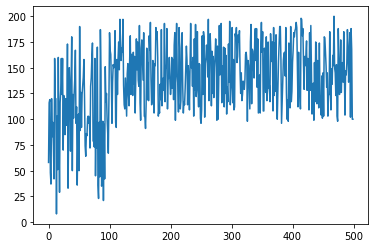

In [29]:
# Plot the reward over time:
import matplotlib.pyplot as plt
plt.plot(range(len(rewards)), rewards)
plt.show()

## Other Applications

### Programs that Need Lots of Flexiblity 

SOOP offer a high degree of flexibility in programming due to the mutability of symbolic objects. This not only enables developers to utilize partial or late binding, but also grants access to the power of rebinding. Program search is just one example of such usage. Additionally, other use cases like flexible function binding and direct manipulation demonstrate the versatility of symbolic objects. For more information on these examples, please refer to [Symbolic Functions](https://pyglove.readthedocs.io/en/latest/notebooks/intro/basics/symbolic_function.html) and [Interactive SVG](https://pyglove.readthedocs.io/en/latest/notebooks/python/interactive_svg.html).

### Representation-centric Systems

Symbolic objects inherently serve as representations, simplifying representation-centric systems when used with SOOP. Machine learning systems are a prime example of such systems that typically rely on a separate configuration system, which is no longer required with PyGlove. For further details on PyGlove's application in machine learning, please refer to the [Symbolic Machine Learning](https://pyglove.readthedocs.io/en/latest/guide/ml/index.html) examples.


### More

PyGlove offers a wide range of capabilities for you to discover, such as the ability to create [domain-specific languages](https://pyglove.readthedocs.io/en/latest/notebooks/python/sticky_notes.html) using symbolic placeholding and develop [context-aware components](https://pyglove.readthedocs.io/en/latest/notebooks/python/where_is_the_duck.html) that can seamlessly adjust to changes in object hierarchy. We are excited to see the innovative ways in which you utilize SOOP and PyGlove and look forward to learning from you.